In [2]:
from HeaderP import *
import Astraea
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
import random

# Nearest

In [45]:
df

,teff,Prot,VD_model,dv_true,v_b,Prot_log,teff_norm,Prot_log_norm,dv_recover,dist
0,3813,1.532,-8.664249,-8.664249,2.617792,0.185259,-1.880465,-2.433043,4.149420,3.592631
1,4261,14.891,4.667716,4.667716,-4.042894,1.172924,-1.261999,0.114620,4.746546,1.925835
2,4122,1.569,-6.063139,-6.063139,-3.918416,0.195623,-1.453889,-2.406308,4.738356,3.283810
3,3760,15.678,0.841100,0.841100,-1.483473,1.195291,-1.953631,0.172315,1.737888,2.618341
4,4045,31.496,16.255531,16.255531,9.263653,1.498255,-1.560188,0.953806,16.657141,2.381025
...,...,...,...,...,...,...,...,...,...,...
30466,4878,23.851,11.234390,11.234390,-4.213404,1.377507,-0.410228,0.642337,11.899625,1.201651
30467,5674,7.345,2.597863,2.597863,-1.910294,0.865992,0.688653,-0.677105,2.746239,0.780931
30468,5720,12.802,6.798923,6.798923,-8.774398,1.107278,0.752156,-0.054713,7.276192,0.181150
30469,6022,3.896,0.631749,0.631749,-0.645705,0.590619,1.169068,-1.387424,0.835464,1.574147


In [8]:
df=pd.read_pickle('vd_model_mass.pkl')
df=df[['Teff','Prot','VD_model']]
df=df.rename(columns={"Teff": "teff"})
df['teff']

0        3813
1        4261
2        4122
3        3760
4        4045
         ... 
30466    4878
30467    5674
30468    5720
30469    6022
30470    5656
Name: teff, Length: 30471, dtype: int64

generate fake VD data that increases with Prot

In [86]:
def dvfunc(prot,temp):
    return 30*np.log10(df['Prot'])+temp/np.median(temp)*15

In [9]:
#df['dv_true']=dvfunc(df['Prot'],df['teff'])
#df['v_b']=np.random.randn(len(df['Prot']))*df['dv_true']
#df['teff'].hist()
df['dv_true']=df['VD_model']
#df['dv_true']=10
df['v_b']=np.random.randn(len(df['Prot']))*df['dv_true']

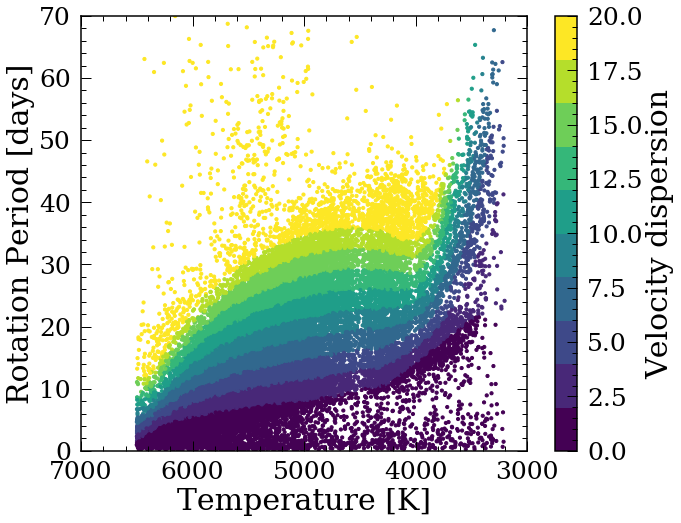

In [10]:
# plot it
v_max,v_min=20,0
cm = plt.cm.get_cmap('viridis',10)
plt.figure(figsize=(10,8))
plt.scatter(df['teff'],df['Prot'],c=df['dv_true'],s=10,vmax=v_max,vmin=0,cmap=cm,edgecolors=None)

plt.xlabel('Temperature [K]')
plt.xlim([3000,7000])
plt.ylim([0,70])
plt.gca().invert_xaxis()
plt.ylabel('Rotation Period [days]')

cb=plt.colorbar()
cb.set_label('Velocity dispersion')
plt.savefig('./bintest/Mass/Truth.png')

In [11]:
def Calcdv(df,f1,f2,NN):
    Nstars=len(df)
    X_nn = StandardScaler().fit_transform(df[[f1,f2]])
    df[f1+'_norm'],df[f2+'_norm'] = X_nn[:,0], X_nn[:,1]
    
    # initialize velocity dispersion
    df['dv_recover']=np.zeros(Nstars)
    for i in range(Nstars):
        update_progress(i/Nstars)
        teff = df.iloc[i][f1+'_norm']
        Prot = df.iloc[i][f2+'_norm']
        df['dist'] = np.sqrt(np.power(df[f1+'_norm']-teff,2.)+np.power(df[f2+'_norm']-Prot,2.))
        
        # get the clossest stadrs v_b
        NNstars=df.loc[df.sort_values(by=['dist']).iloc[0:NN].index]
    
        #MAD=sum(abs(NNstars['v_b']-np.median(NNstars['v_b'])))/float(len(NNstars))

        #df['dv_recover'].iloc[i]=1.5*MAD
        df['dv_recover'].iloc[i]=np.std(NNstars['v_b'])

In [32]:
NN=100
df['Prot_log']=np.log10(df['Prot'])
Calcdv(df,'teff','Prot_log',NN)

Progress: [####################] 100.0%


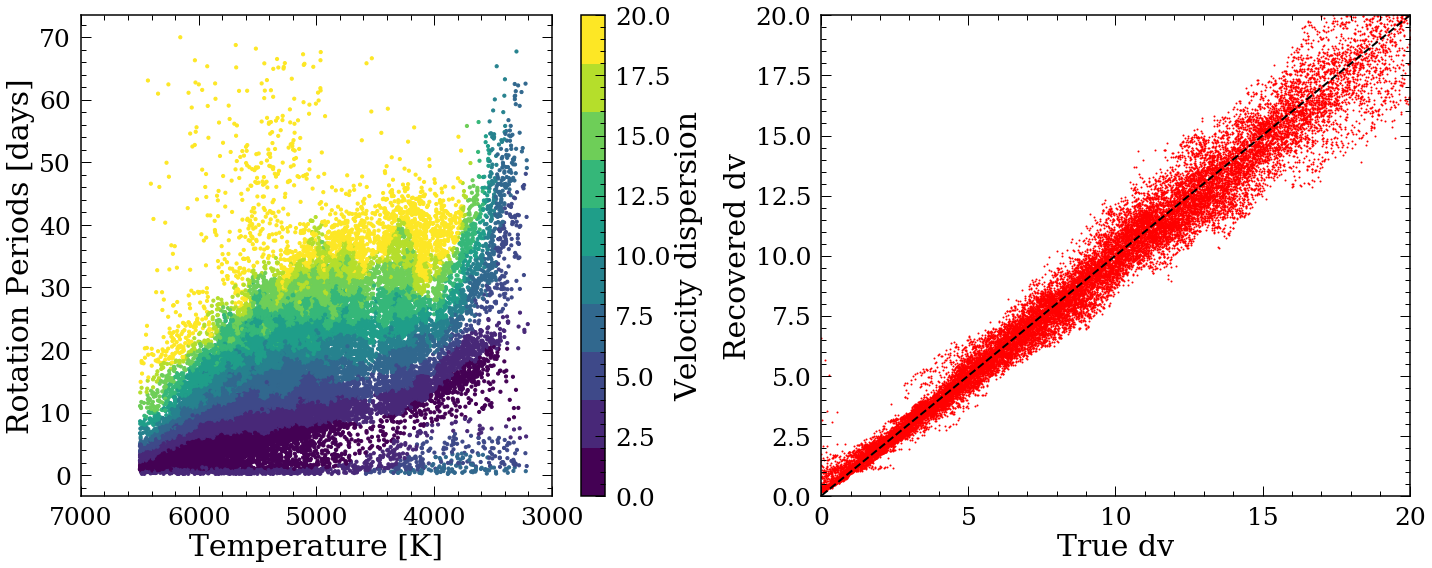

In [33]:
# plot it
cm = plt.cm.get_cmap('viridis',10)
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.scatter(df['teff'],df['Prot'],c=df['dv_recover'],vmax=v_max,vmin=0,s=10,cmap=cm,edgecolors=None)

plt.xlabel('Temperature [K]')
plt.xlim([3000,7000])
plt.gca().invert_xaxis()
plt.ylabel('Rotation Periods [days]')

cb=plt.colorbar()
cb.set_label('Velocity dispersion')

plt.subplot(1,2,2)
plt.scatter(df['dv_true'],df['dv_recover'],s=1,c='r')
plt.plot([min(df['dv_true']),max(df['dv_true'])],[min(df['dv_true']),max(df['dv_true'])],'k--')
plt.ylim([0,20])
plt.xlim([0,20])
plt.ylabel('Recovered dv')
plt.xlabel('True dv')
plt.tight_layout()
plt.savefig('./bintest/Mass/shift_11_NN_%d'%(NN)+'.png')


# Try bins

In [19]:
def Calcdv_bin(df,f1,f2,binsize_temp,binsize_rot):
    Nstars=len(df)
    
    # initialize velocity dispersion
    df['dv_recover']=np.zeros(Nstars)
    for i in range(Nstars):
        update_progress(i/Nstars)
        teff = df.iloc[i][f1]
        Prot = df.iloc[i][f2]
        
        
        mask_df1=(df[f1]>teff-binsize_temp/2) & (df[f1]<teff+binsize_temp/2)
        mask_df2=(df[f2]>Prot-binsize_rot/2) & (df[f2]<Prot+binsize_rot/2)
        totmask=mask_df1 & mask_df2

        # get the clossest stadrs v_b
        NNstars=df.loc[totmask]
    
        #MAD=sum(abs(NNstars['v_b']-np.median(NNstars['v_b'])))/float(len(NNstars))

        #df['dv_recover'].iloc[i]=1.5*MAD
        df['dv_recover'].iloc[i]=np.std(NNstars['v_b'])


In [43]:
bintemp=300
binprot=0.15
df['Prot_log']=np.log10(df['Prot'])
Calcdv_bin(df,'teff','Prot_log',bintemp,binprot)

Progress: [####################] 100.0%


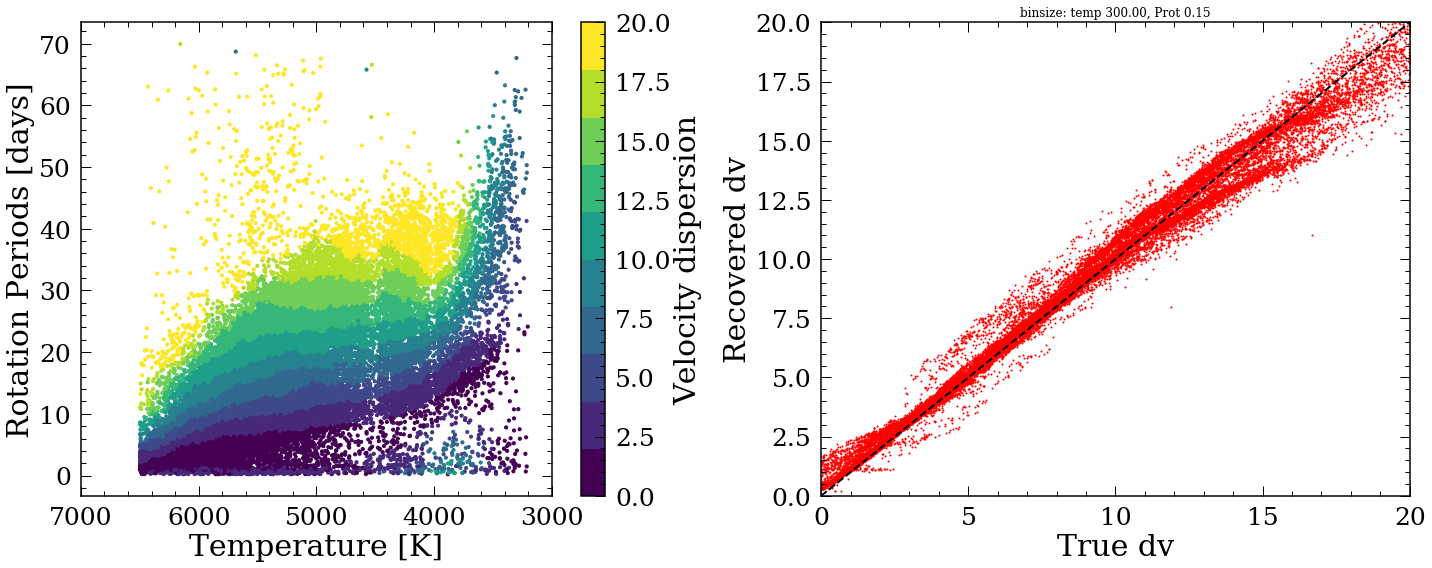

In [44]:
# plot it
cm = plt.cm.get_cmap('viridis',10)
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.scatter(df['teff'],df['Prot'],c=df['dv_recover'],vmax=v_max,vmin=0,s=10,cmap=cm,edgecolors=None)

plt.xlabel('Temperature [K]')
plt.xlim([3000,7000])
plt.gca().invert_xaxis()
plt.ylabel('Rotation Periods [days]')

cb=plt.colorbar()
cb.set_label('Velocity dispersion')

plt.subplot(1,2,2)
plt.scatter(df['dv_true'],df['dv_recover'],s=1,c='r')
plt.plot([min(df['dv_true']),max(df['dv_true'])],[min(df['dv_true']),max(df['dv_true'])],'k--')
plt.title('binsize: temp %.2f, Prot %.2f'%(bintemp,binprot))
plt.ylabel('Recovered dv')
plt.xlabel('True dv')
plt.ylim([0,20])
plt.xlim([0,20])
plt.tight_layout()
plt.savefig('./bintest/Mass/temp_%.2f_Prot %.2f'%(bintemp,binprot)+'.png')



In [48]:
df2=pd.read_table('Rvars4year',delimiter=',')
kids=pd.read_pickle('KIDs.pkl')

,KID,Rvar


In [56]:
kids.loc[~kids.isin(df2['KID'])].to_pickle('KIDs.pkl')